# Replication Code (Python): Age, Income, and the Discounting of Delayed Monetary Losses

This Jupyter Notebook provides a complete Python-based replication of the analyses from the publication:

> Wan, H., Myerson, J., Green, L., Strube, M. J., & Hale, S. (2025). Age, income, and the discounting of delayed monetary losses. *The Journals of Gerontology, Series B: Psychological Sciences and Social Sciences, 80*(11), gbaf162. https://doi.org/10.1093/geronb/gbaf162

The original analysis, conducted in R, has been translated into a Python workflow. This notebook demonstrates proficiency in replicating complex statistical analyses across different programming ecosystems.

### Workflow Overview

1.  **Setup**: Imports all necessary Python libraries and defines custom functions for modeling and plotting.
2.  **Data Processing**: Loads the raw data and cleans it using `pandas`, preparing it for analysis.
3.  **Descriptive & Correlational Analyses**: Replicates the paper's descriptive statistics, visualizations (Figure 1), and correlation tables using `matplotlib`, `seaborn`, and `pingouin`.
4.  **Hypothesis Testing**: Fits the main Bayesian multilevel beta regression models from the paper (Table 3) using `pymc`.
5.  **Supplementary Analyses**: Fits additional models to test the roles of depression and overall distress.
6.  **Interaction Plots**: Generates visualizations for the key model interactions (Figure 4), demonstrating the ability to interpret and communicate complex model findings.

The data for this study are available in the Supplementary Material at the publisher's website.

In [25]:
# --- 1. Environment Setup ---
# This cell installs all the required Python packages.
# It is commented out by default. Uncomment and run this cell if the packages are not yet installed in your environment.

# import sys
# !{sys.executable} -m pip install openpyxl pandas numpy scipy statsmodels pymc arviz matplotlib seaborn pingouin patsy jax jaxlib

In [26]:
# --- 1. SETUP: IMPORTS AND CUSTOM FUNCTIONS ---

# --- Core Libraries ---
import pandas as pd
import numpy as np
import warnings
import patsy
from scipy.optimize import curve_fit
import os
import pickle
import hashlib

# --- Statistics and Modeling ---
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc as pm
import arviz as az
import pingouin as pg

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global Settings ---
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

# --- Custom Functions ---
def scale_var(series):
    return (series - series.mean()) / (2 * series.std())

def hyperboloid(delay, k, s):
    """Mathematical function for hyperboloid discounting."""
    return 1 / (1 + np.exp(k) * delay)**s

def set_plot_theme(ax, title="", xlabel="", ylabel=""):
    """Applies a consistent, publication-quality theme to a Matplotlib axes object."""
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold', labelpad=10)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.set_facecolor('white')
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10, direction='in')
    if ax.get_legend():
        ax.legend(frameon=False, title_fontproperties={'weight':'bold', 'size': 12})

# Note: We use np.trapz(y, x) for the trapezoidal rule, which is the direct
# equivalent of the custom R function.

def betaMLM_pymc(formula, data, file=None):
    """
    Fits a Bayesian multilevel beta regression model using PyMC, mirroring brms.

    This function uses patsy to parse the model formula, constructs the model in 
    PyMC with weakly informative priors analogous to the R script, and samples 
    from the posterior. It includes a file-caching mechanism to avoid re-running.

    Args:
        formula (str): A patsy-style formula (e.g., "y ~ x1 + (1|ID)").
                       Random effects are limited to a simple random intercept on ID.
        data (pd.DataFrame): The dataframe containing the model variables.
        file (str, optional): Path to save/load the fitted model object, 
                              enabling caching. Defaults to None.

    Returns:
        arviz.InferenceData: The fitted model object containing posterior samples.
    """
    if file and os.path.exists(file):
        print(f"Loading cached model from {file}...")
        return az.from_netcdf(file)

    coords = {}
    if '(1|ID)' in formula:
        fixed_formula = formula.partition('(1|ID)')[0].strip().rstrip('+').strip()
        has_re = True
        id_idx, id_cats = pd.factorize(data['ID'])
        coords['ID_dim'] = id_cats
    else:
        fixed_formula = formula
        has_re = False

    y_patsy, X_patsy = patsy.dmatrices(fixed_formula, data=data)
    y_name = y_patsy.design_info.column_names[0]
    y_data = np.asarray(y_patsy).ravel()
    X_data = np.asarray(X_patsy)
    X_cols = X_patsy.design_info.column_names
    
    y_data[y_data == 1] = 1 - np.finfo(float).eps
    y_data[y_data == 0] = np.finfo(float).eps

    with pm.Model(coords=coords) as model:
        intercept = pm.Normal('Intercept', mu=0, sigma=1000)
        slopes = pm.Cauchy('slopes', alpha=0, beta=2.5, shape=X_data.shape[1] - 1)
        betas = pm.math.concatenate([[intercept], slopes])
        
        nu = pm.HalfNormal('nu', sigma=100) # Precision parameter

        if has_re:
            sigma_id = pm.HalfCauchy('sigma_id', beta=2.5)
            z_id = pm.Normal('z_id', mu=0, sigma=1, dims='ID_dim')
            intercept_id = pm.Deterministic('intercept_id', z_id * sigma_id, dims='ID_dim')

        eta = pm.math.dot(X_data, betas)
        if has_re:
            eta += intercept_id[id_idx]

        mu = pm.math.invlogit(eta)
        
        pm.Beta(y_name, mu=mu, nu=nu, observed=y_data)
        
        idata = pm.sample(
            draws=2000, 
            tune=2000, 
            chains=1, 
            cores=1, 
            progressbar=False, 
            target_accept=0.95
        )
        
        # Unpack the 'slopes' variable into named variables for a cleaner summary
        slopes_data = idata.posterior['slopes']
        slope_names = [col for col in X_cols if col != 'Intercept']
        
        # Find the name of the dimension to index along
        dim_name = [dim for dim in slopes_data.dims if dim not in ('chain', 'draw')][0]

        for i, name in enumerate(slope_names):
            # Create a new variable for each slope, correctly indexed
            idata.posterior[name] = slopes_data.isel({dim_name: i})
            
        # Drop the original multi-dimensional 'slopes' variable
        idata.posterior = idata.posterior.drop_vars('slopes')

    if file:
        print(f"Saving model to {file}...")
        idata.to_netcdf(file)
        
    return idata

def pymc_summary(idata, rownames=None):
    """
    Creates a formatted summary table from a fitted PyMC model, mirroring brm_summary.

    Args:
        idata (arviz.InCaseData): The fitted model object.
        rownames (list, optional): A list of strings to rename the model parameters 
                                  in the final output table.

    Returns:
        pd.DataFrame: A formatted summary table with posterior medians, standard 
                      deviations, and probability of direction (pd).
    """
    stat_funcs = {
        "Est.": np.median,
        "SE": np.std
    }
    
    # Get fixed-effect variable names, excluding random effect parameters
    # and the precision parameter 'nu'.
    var_names = [v for v in idata.posterior.data_vars if v not in 
                 ['intercept_id', 'z_id', 'sigma_id', 'nu']]
    
    summary_df = az.summary(
        idata, 
        var_names=var_names, 
        kind="stats", 
        stat_funcs=stat_funcs, 
        extend=False
    )

    pd_values = []
    for var in summary_df.index:
        # Pass the var string directly to az.extract
        samples = az.extract(idata, var_names=var).values
        
        pd_val = np.mean(samples > 0)
        pd_values.append(max(pd_val, 1 - pd_val))
    summary_df['pd'] = pd_values

    def format_num(x):
        return f"{x:.3f}".replace("0.", ".")

    est_formatted = summary_df['Est.'].apply(format_num)
    se_formatted = summary_df['SE'].apply(lambda x: f"({format_num(x)})")
    summary_df["Est.(SE)"] = est_formatted + " " + se_formatted
    
    def format_pd(x):
        if np.isclose(x, 1.0):
            return ">.999"
        return format_num(x)
    summary_df["pd"] = summary_df["pd"].apply(format_pd)
    
    summary_df.index = summary_df.index.str.replace("I(", "", regex=False).str.replace(" ** 2", "^2", regex=False).str.replace(")", "", regex=False)
    
    if rownames:
        summary_df.index = rownames

    return summary_df[['Est.(SE)', 'pd']]

# This is a Python translation of the R power analysis function.
# NOTE: It uses statsmodels GLM (not a mixed model) as a frequentist approximation
# of glmmTMB, as a direct equivalent for Beta GLMMs is not available.
def SimPower_MLM(n_ID, beta1, beta2, nu=12.2, sigma=0.944, n_sim=10):
    """Simulation-based power analysis for multilevel beta regression."""
    results = []
    print(f"Running {n_sim} simulations...")
    for i in range(n_sim):
        # Data generation logic translated from R
        group_ids = np.repeat(np.arange(n_ID * 6), 3)
        ages_list = [np.random.uniform(20, 29, n_ID), np.random.uniform(30, 39, n_ID),
                     np.random.uniform(40, 49, n_ID), np.random.uniform(50, 59, n_ID),
                     np.random.uniform(60, 69, n_ID), np.random.uniform(70, 80, n_ID)]
        Age = np.repeat(np.concatenate(ages_list), 3)
        Income = np.repeat(np.random.binomial(4, 0.5, n_ID * 6) + 1, 3)
        b = np.repeat(np.random.normal(0, sigma, n_ID * 6), 3)
        
        eta = b + (beta1 / (2 * Age.std())) * Age + (beta2 / (2 * Income.std())) * Income
        mu = 1 / (1 + np.exp(-eta))
        AuC = np.random.beta(mu * nu, (1 - mu) * nu)
        AuC = np.clip(AuC, 1e-9, 1 - 1e-9)
        
        sim_dat = pd.DataFrame({'ID': group_ids, 'Age': Age, 'Income': Income, 'AuC': AuC})
        
        # Fit models
        try:
            dat_20_80 = sim_dat.copy()
            dat_20_80['Age_std'] = (dat_20_80['Age'] - dat_20_80['Age'].mean()) / (2 * dat_20_80['Age'].std())
            
            dat_35_80 = sim_dat[sim_dat['Age'] >= 35].copy()
            dat_35_80['Age_std'] = (dat_35_80['Age'] - dat_35_80['Age'].mean()) / (2 * dat_35_80['Age'].std())
            dat_35_80['Income_std'] = (dat_35_80['Income'] - dat_35_80['Income'].mean()) / (2 * dat_35_80['Income'].std())
            
            # Using GLM as approximation of GLMM
            fit1 = smf.glm('AuC ~ Age_std', data=dat_20_80, family=sm.families.Binomial()).fit()
            fit2 = smf.glm('AuC ~ Age_std + Income_std', data=dat_35_80, family=sm.families.Binomial()).fit()
            
            results.append([fit1.pvalues['Age_std'], fit2.pvalues['Age_std'], fit2.pvalues['Income_std']])
        except:
            results.append([np.nan, np.nan, np.nan])
            
    p_values = pd.DataFrame(results, columns=['p1', 'p2', 'p3'])
    power = (p_values < 0.05).mean()
    return power.values

In [27]:
# --- 2. DATA LOADING AND PROCESSING ---

# Load the raw data from the specified sheet in the Excel file
Disc_Raw = pd.read_excel("Supplementary Data.xlsx", sheet_name=1)

# --- Feature Engineering and Cleaning ---
# Create Age_Group factor for plotting
age_bins = [19, 34, 50, 64, 80]
age_labels = ["20-34", "35-50", "51-64", "65-80"]
Disc_Raw['age_grp_factor'] = pd.cut(Disc_Raw['Age'], bins=age_bins, labels=age_labels)

# Log-transform Amount
amount_map = {1: 150, 3: 30000, 2: 2500}
Disc_Raw['Amount_log'] = np.log(Disc_Raw['Amount'].map(amount_map))

# Ensure correct data types
for col in ['Income', 'Education', 'Distress', 'Anxiety', 'Depression']:
    Disc_Raw[col] = pd.to_numeric(Disc_Raw[col], errors='coerce')

# --- Create Group-Level Dataframe for Plotting ---
Disc_Grp = Disc_Raw.copy()
Disc_Grp['Amount'] = Disc_Grp['Amount'].map({150: "$150", 2500: "$2,500", 30000: "$30,000"})
Disc_Grp['Amount'] = pd.Categorical(Disc_Grp['Amount'], categories=["$150", "$2,500", "$30,000"], ordered=True)
Disc_Grp = Disc_Grp.groupby(['age_grp_factor', 'Amount', 'Delay'], observed=True).agg(Mean_RSV=('RSV', 'mean')).reset_index()

# --- Calculate Area under the Curve (AuC) for Each Individual ---
AuC_ID = Disc_Raw.sort_values('Delay').groupby(['ID', 'Amount']).apply(
    lambda g: np.trapz(y=g['RSV'], x=g['Delay'] / g['Delay'].max())
).reset_index(name='AuC')

# Join back demographic information
demographics = Disc_Raw.drop_duplicates(subset='ID').drop(columns=['Amount', 'Delay', 'RSV', 'Amount_log'])
AuC_ID = pd.merge(AuC_ID, demographics, on='ID', how='left')

# Clip AuC values for Beta regression
AuC_ID['AuC'] = np.clip(AuC_ID['AuC'], 1e-9, 1 - 1e-9)

# Data for Model 1
DL_dat1 = AuC_ID[AuC_ID['Age'] >= 35].copy()
DL_dat1['Age_std'] = scale_var(DL_dat1['Age'])

# Data for Model 2
DL_dat2 = AuC_ID[(AuC_ID['Age'] >= 35) & AuC_ID['Income'].notna()].copy()
for col in ['Age', 'Income']:
    DL_dat2[f'{col}_std'] = scale_var(DL_dat2[col])

# Data for Models 3, S1, S3
DL_dat3 = AuC_ID[(AuC_ID['Age'] >= 35) & AuC_ID['Income'].notna() & AuC_ID['Distress'].notna()].copy()
for col in ['Age', 'Income', 'Anxiety', 'Depression', 'Distress']:
    DL_dat3[f'{col}_std'] = scale_var(DL_dat3[col])

# Data for Full Models (4, S2, S4)
DL_dat4 = AuC_ID[
    (AuC_ID['Age'] >= 35) & (AuC_ID['Income'].notna()) & (AuC_ID['Gender'].notna()) &
    (AuC_ID['Education'].notna()) & (AuC_ID['Distress'].notna()) & (AuC_ID['Health'].notna())
].copy()
for col in ['Age', 'Amount', 'Income', 'Education', 'Anxiety', 'Depression', 'Distress', 'Health']:
    DL_dat4[f'{col}_std'] = scale_var(DL_dat4[col])
DL_dat4['Gender_c'] = DL_dat4['Gender'] - DL_dat4['Gender'].mean()

## Descriptive & Correlational Analyses

This section replicates the descriptive results from the paper, including the visualization of group-level discounting functions (Figure 1), goodness-of-fit statistics for the hyperboloid model, reliability of the AuC measure, and the correlation matrices for key variables.

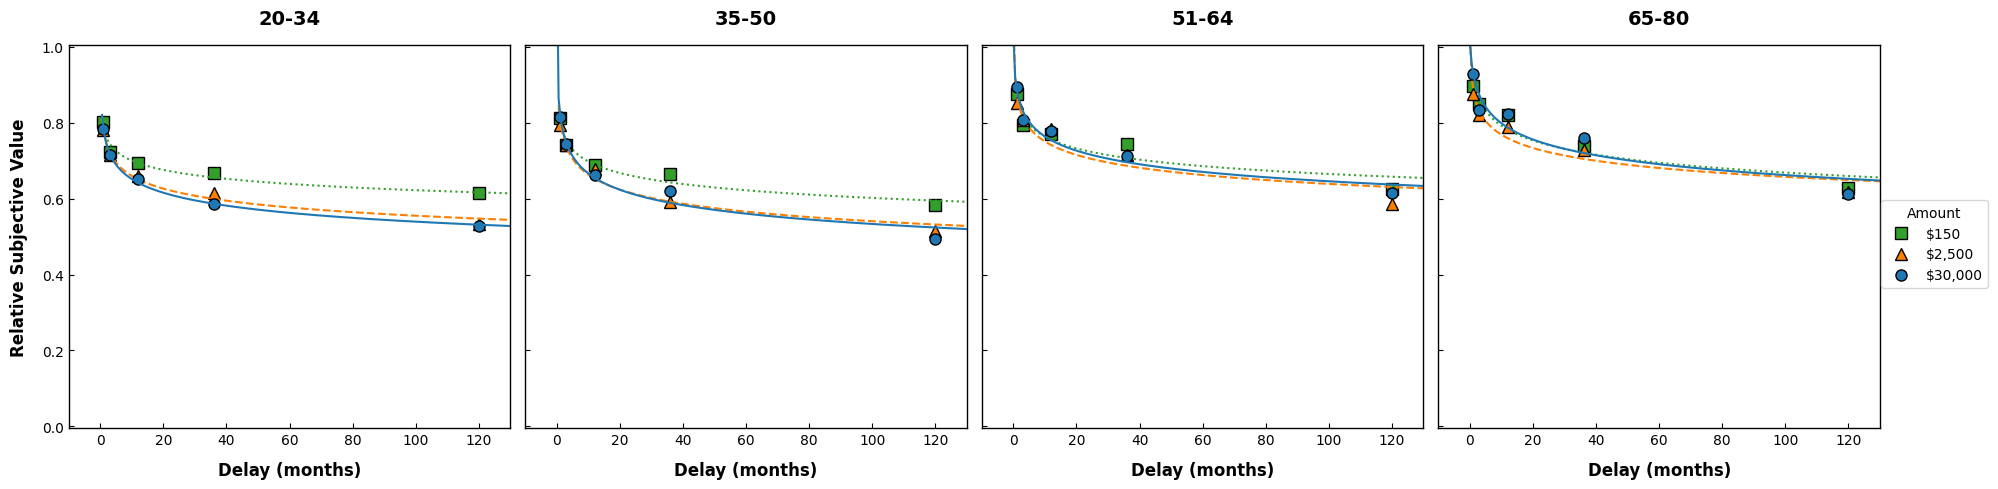


--- R-squared for Group-Level Hyperboloid Fits ---


Amount,$150,"$2,500","$30,000"
age_grp_factor,,,
20-34,0.956,0.983,0.997
35-50,0.973,0.976,0.965
51-64,0.898,0.878,0.955
65-80,0.925,0.926,0.890



--- P-values for Amount Effect within each Age Group ---


,p_value
age_grp_factor,
20-34,0.002
35-50,0.003
51-64,0.340
65-80,0.527


In [28]:
# --- 4. DESCRIPTIVE & CORRELATIONAL ANALYSES ---

# --- 4.1 Figure 1 Replication: Group-Level Discounting Functions ---

# --- Create Plot ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
colors = {"$150": "#33a02c", "$2,500": "#ff7f00", "$30,000": "#1f78b4"}
shapes = {"$150": "s", "$2,500": "^", "$30,000": "o"}
linestyles = {"$150": "dotted", "$2,500": "dashed", "$30,000": "solid"}

for i, (age_group, group_df) in enumerate(Disc_Grp.groupby('age_grp_factor', observed=True)):
    ax = axes[i]
    for amount, amount_df in group_df.groupby('Amount', observed=True):
        ax.plot(amount_df['Delay'], amount_df['Mean_RSV'], marker=shapes[amount], linestyle='',
                color=colors[amount], label=amount, markersize=8, markeredgecolor='black')
        
        # Fit and plot curve
        try:
            popt, _ = curve_fit(hyperboloid, amount_df['Delay'], amount_df['Mean_RSV'], p0=[-4, 0.5])
            x_pred = np.linspace(-10, 130, 200)
            ax.plot(x_pred, hyperboloid(x_pred, *popt), color=colors[amount], linestyle=linestyles[amount], lw=1.5)
        except RuntimeError:
            print(f"Curve fit failed for {age_group}, {amount}")
    
    set_plot_theme(ax, title=age_group, xlabel="Delay (months)" if i == 0 else "Delay (months)")
    ax.set_ylim(-0.005, 1.005)
    ax.set_xlim(-10, 130)

# Add a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='Amount', bbox_to_anchor=(1.0, 0.5))
axes[0].set_ylabel("Relative Subjective Value", fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

# --- Goodness-of-Fit for Group-Level Hyperboloid Functions ---
print("\n--- R-squared for Group-Level Hyperboloid Fits ---")
r2_results = Disc_Grp.groupby(['age_grp_factor', 'Amount'], observed=True).apply(
    lambda grp: r2_score(grp['Mean_RSV'], hyperboloid(grp['Delay'], *curve_fit(hyperboloid, grp['Delay'], grp['Mean_RSV'], p0=[-4, 0.5])[0]))
).unstack()
display(r2_results)

# --- Test for the "Amount Effect" ---
print("\n--- P-values for Amount Effect within each Age Group ---")
# analysis for a within-subjects factor within each level of a between-subjects group.
amount_effect_pvals = AuC_ID.groupby('age_grp_factor', observed=True).apply(
    lambda g: pg.rm_anova(data=g, dv='AuC', within='Amount', subject='ID')['p-unc'][0]
).rename('p_value').to_frame()
display(amount_effect_pvals)

### Reliability and Correlational Analyses

This section assesses the internal consistency of the Area under the Curve (AuC) measure across the three different loss amounts. It also replicates the correlation matrices from the paper for both the full sample (ages 20-80) and the primary analysis sample (ages 35-80).

In [29]:
# --- 4.2 Reliability of AuC Measure (Cronbach's Alpha) ---
print("--- Reliability of AuC Measure (Cronbach's Alpha) ---")
# Pivot the data to have one row per participant and one column per amount
reliability_df = AuC_ID.pivot(index='ID', columns='Amount', values='AuC')
# Calculate Cronbach's Alpha
display(pg.cronbach_alpha(data=reliability_df))

# --- 4.3 Correlation Matrix for All Participants (Aged 20-80) ---
print("\n--- Correlation Matrix for All Participants (Aged 20-80) ---")
# First, average the repeated measures for each participant
Cor_df_full = AuC_ID.groupby('ID').agg({
    'Age': 'mean', 'Income': 'mean', 'Education': 'mean', 'Gender': 'mean', 
    'Distress': 'mean', 'Anxiety': 'mean', 'Depression': 'mean', 
    'Health': 'mean', 'AuC': 'mean'
})
# Calculate and display the Pearson correlation matrix
display(Cor_df_full.corr(method='pearson').round(3))

# --- 4.4 Correlation Matrix for Participants Aged 35-80 (Table 2 Replication) ---
print("\n--- Correlation Matrix for Participants Aged 35-80 ---")
# Filter the data to the specified age range, then average and correlate
Cor_df_35plus = AuC_ID[AuC_ID['Age'] >= 35].groupby('ID').agg({
    'Age': 'mean', 'Income': 'mean', 'Education': 'mean', 'Gender': 'mean', 
    'Distress': 'mean', 'Anxiety': 'mean', 'Depression': 'mean', 
    'Health': 'mean', 'AuC': 'mean'
})
display(Cor_df_35plus.corr(method='pearson').round(3))

--- Reliability of AuC Measure (Cronbach's Alpha) ---


(np.float64(0.8601565041438437), array([0.839, 0.879]))


--- Correlation Matrix for All Participants (Aged 20-80) ---


,Age,Income,Education,Gender,Distress,Anxiety,Depression,Health,AuC
Age,1.000,-0.025,-0.009,-0.002,-0.292,-0.338,-0.180,-0.081,0.189
Income,-0.025,1.000,0.384,-0.083,-0.146,-0.133,-0.132,0.229,0.094
Education,-0.009,0.384,1.000,-0.036,-0.158,-0.126,-0.167,0.186,0.032
Gender,-0.002,-0.083,-0.036,1.000,0.098,0.132,0.035,-0.023,-0.042
Distress,-0.292,-0.146,-0.158,0.098,1.000,0.929,0.886,-0.458,-0.142
Anxiety,-0.338,-0.133,-0.126,0.132,0.929,1.000,0.650,-0.347,-0.168
Depression,-0.180,-0.132,-0.167,0.035,0.886,0.650,1.000,-0.498,-0.067
Health,-0.081,0.229,0.186,-0.023,-0.458,-0.347,-0.498,1.000,0.079
AuC,0.189,0.094,0.032,-0.042,-0.142,-0.168,-0.067,0.079,1.000



--- Correlation Matrix for Participants Aged 35-80 ---


,Age,Income,Education,Gender,Distress,Anxiety,Depression,Health,AuC
Age,1.000,-0.031,0.011,-0.029,-0.281,-0.325,-0.174,0.026,0.206
Income,-0.031,1.000,0.388,-0.132,-0.207,-0.193,-0.177,0.286,0.114
Education,0.011,0.388,1.000,-0.100,-0.189,-0.171,-0.173,0.224,0.017
Gender,-0.029,-0.132,-0.100,1.000,0.153,0.174,0.095,-0.036,-0.045
Distress,-0.281,-0.207,-0.189,0.153,1.000,0.932,0.893,-0.515,-0.149
Anxiety,-0.325,-0.193,-0.171,0.174,0.932,1.000,0.670,-0.411,-0.169
Depression,-0.174,-0.177,-0.173,0.095,0.893,0.670,1.000,-0.540,-0.084
Health,0.026,0.286,0.224,-0.036,-0.515,-0.411,-0.540,1.000,0.096
AuC,0.206,0.114,0.017,-0.045,-0.149,-0.169,-0.084,0.096,1.000


## Hypothesis Testing: Bayesian Multilevel Models

This section replicates the main hypothesis tests from the paper, corresponding to Table 3. A series of four Bayesian multilevel beta regression models are fitted to test the effects of age, income, anxiety, and other covariates on AuC for participants aged 35 and older.

In [30]:
# --- 5. HYPOTHESIS TESTING: MAIN MODELS ---

# --- Model 1: AuC ~ Age + Age^2 ---
# Tests for a linear and quadratic effect of age on discounting.
print("--- Model 1: AuC ~ Age + Age^2 ---")
idata_mod1b = betaMLM_pymc("AuC ~ Age_std + I(Age_std**2) + (1|ID)", DL_dat1)
print(pymc_summary(idata_mod1b))

# --- Model 2: AuC ~ Age + Age^2 + Income ---
# Adds income as a predictor.
print("\n--- Model 2: AuC ~ Age + Age^2 + Income ---")
idata_mod2 = betaMLM_pymc("AuC ~ Age_std + I(Age_std**2) + Income_std + (1|ID)", DL_dat2)
print(pymc_summary(idata_mod2))

# --- Model 3: AuC ~ Age + Age^2 + Income + Anxiety ---
# Adds anxiety as a predictor.
print("\n--- Model 3: AuC ~ Age + Age^2 + Income + Anxiety ---")
idata_mod3 = betaMLM_pymc("AuC ~ Age_std + I(Age_std**2) + Income_std + Anxiety_std + (1|ID)", DL_dat3)
print(pymc_summary(idata_mod3))

# --- Model 4: Full Model with Covariates and Age Interactions ---
# The full model includes all covariates and their interactions with age.
print("\n--- Model 4: Full Model with Covariates and Age Interactions ---")
formula_mod4 = "AuC ~ (Age_std + Income_std + Anxiety_std + Amount_std + Education_std + Gender_c + Health_std)**2 + I(Age_std**2) + (1|ID)"
idata_mod4 = betaMLM_pymc(formula_mod4, DL_dat4)
print(pymc_summary(idata_mod4))

--- Model 1: AuC ~ Age + Age^2 ---


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, slopes, nu, sigma_id, z_id]
Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...


               Est.(SE)     pd
Intercept   .994 (.090)  >.999
Age_std     .444 (.116)  >.999
Age_std^2  -.573 (.277)   .981

--- Model 2: AuC ~ Age + Age^2 + Income ---


Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, slopes, nu, sigma_id, z_id]
Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...


                Est.(SE)     pd
Intercept   1.015 (.092)  >.999
Age_std      .467 (.116)  >.999
Age_std^2   -.633 (.274)   .989
Income_std   .279 (.119)   .986

--- Model 3: AuC ~ Age + Age^2 + Income + Anxiety ---


Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, slopes, nu, sigma_id, z_id]
Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...


                 Est.(SE)     pd
Intercept    1.003 (.092)  >.999
Age_std       .372 (.132)   .999
Age_std^2    -.591 (.282)   .974
Income_std    .249 (.120)   .981
Anxiety_std  -.303 (.128)   .991

--- Model 4: Full Model with Covariates and Age Interactions ---


Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, slopes, nu, sigma_id, z_id]
Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


                               Est.(SE)     pd
Intercept                  1.004 (.109)  >.999
Age_std                     .371 (.138)  1.000
Income_std                  .279 (.147)   .970
Anxiety_std                -.243 (.158)   .933
Amount_std                 -.066 (.047)   .926
Education_std              -.068 (.147)   .678
Gender_c                   -.032 (.123)   .606
Health_std                  .092 (.141)   .748
Age_std:Income_std          .267 (.299)   .805
Age_std:Anxiety_std        -.180 (.305)   .694
Age_std:Amount_std          .254 (.096)   .996
Age_std:Education_std       .086 (.273)   .615
Age_std:Gender_c           -.005 (.277)   .509
Age_std:Health_std         -.101 (.311)   .629
Income_std:Anxiety_std      .453 (.319)   .929
Income_std:Amount_std      -.012 (.101)   .549
Income_std:Education_std    .088 (.271)   .620
Income_std:Gender_c        -.182 (.270)   .743
Income_std:Health_std      -.025 (.304)   .532
Anxiety_std:Amount_std      .044 (.106)   .663
Anxiety_std:E

## Supplementary Analyses: Depression and Distress Models

The paper notes that while anxiety was a significant predictor of discounting, depression and overall psychological distress were not (when controlling for age and income). This section presents the models that confirm these findings.

In [31]:
# --- 6. SUPPLEMENTARY ANALYSES: DEPRESSION & DISTRESS ---

# --- Model S1: Test effect of Depression ---
print("--- Model S1: AuC ~ Age + Age^2 + Income + Depression ---")
idata_modS1 = betaMLM_pymc("AuC ~ Age_std + I(Age_std**2) + Income_std + Depression_std + (1|ID)", DL_dat3)
print(pymc_summary(idata_modS1))

# --- Model S3: Test effect of Distress ---
print("\n--- Model S3: AuC ~ Age + Age^2 + Income + Distress ---\n")
idata_modS3 = betaMLM_pymc("AuC ~ Age_std + I(Age_std**2) + Income_std + Distress_std + (1|ID)", DL_dat3)
print(pymc_summary(idata_modS3))

--- Model S1: AuC ~ Age + Age^2 + Income + Depression ---


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, slopes, nu, sigma_id, z_id]
Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...


                    Est.(SE)     pd
Intercept       1.004 (.095)  >.999
Age_std          .460 (.121)  >.999
Age_std^2       -.570 (.289)   .977
Income_std       .285 (.122)   .993
Depression_std  -.057 (.122)   .672

--- Model S3: AuC ~ Age + Age^2 + Income + Distress ---



Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, slopes, nu, sigma_id, z_id]
Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


                  Est.(SE)     pd
Intercept     1.004 (.097)  >.999
Age_std        .401 (.131)  >.999
Age_std^2     -.579 (.284)   .984
Income_std     .258 (.124)   .978
Distress_std  -.192 (.129)   .935
